# Introduction

In this project we'll be performing sentiment analysis on Rotten Tomatoes Dataset whose dataset has been attached in this repo

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

0 → Negative      </br>
1 → Somewhat negative  </br>
2 → Neutral </br>
3 → Somewhat positive </br>
4 → Positive </br>



We will be comparing performance of BiLSTM Model

# Steps to be followed

1. Importing necessary libraries
2. Opening the train and test dataset in the form of pandas dataframe and perform exploratory data analysis on train data 
3. Taking the train data and splitting it into train and val dataset using <tt>**StratifiedSplit()**</tt>
4. Performing text preprocessing like pattern matching using regex , word tokenization , lemmatization
5. Building the LSTM model and training it
6. Analysing the performance of model
7. Future improvments

### Step 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## other libraries will be imported as and when required

## Step 2. Opening the dataset and performing EDA

In [2]:
train_df = pd.read_csv('../input/sentimentdata/train.tsv/train.tsv' , sep='\t')
test_df = pd.read_csv('../input/sentimentdata/test.tsv/test.tsv' , sep = '\t')

In [3]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print(train_df.shape)
#print(train_df.info)
print(train_df.columns)
print(train_df.isnull().sum())

(156060, 4)
Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64


<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

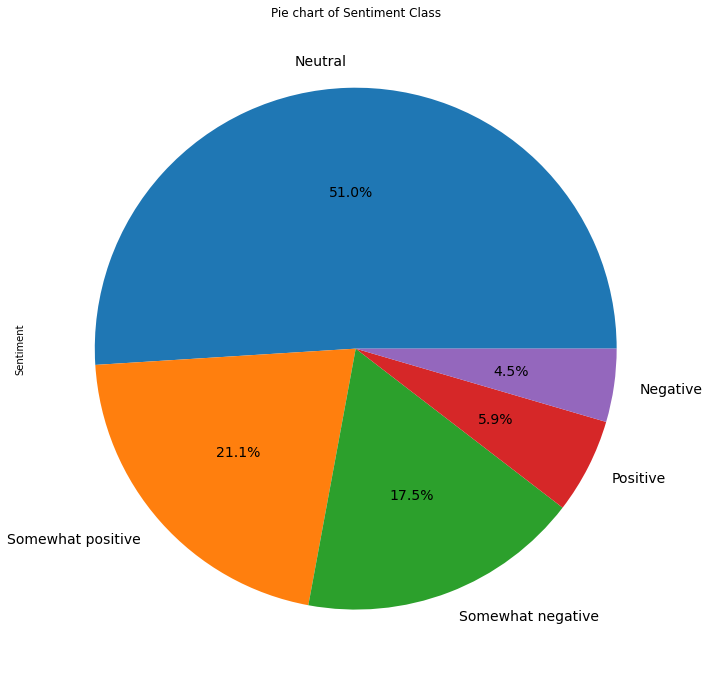

In [5]:
df2=train_df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Text(0.5, 0.98, 'Histogram number of words in reviews')

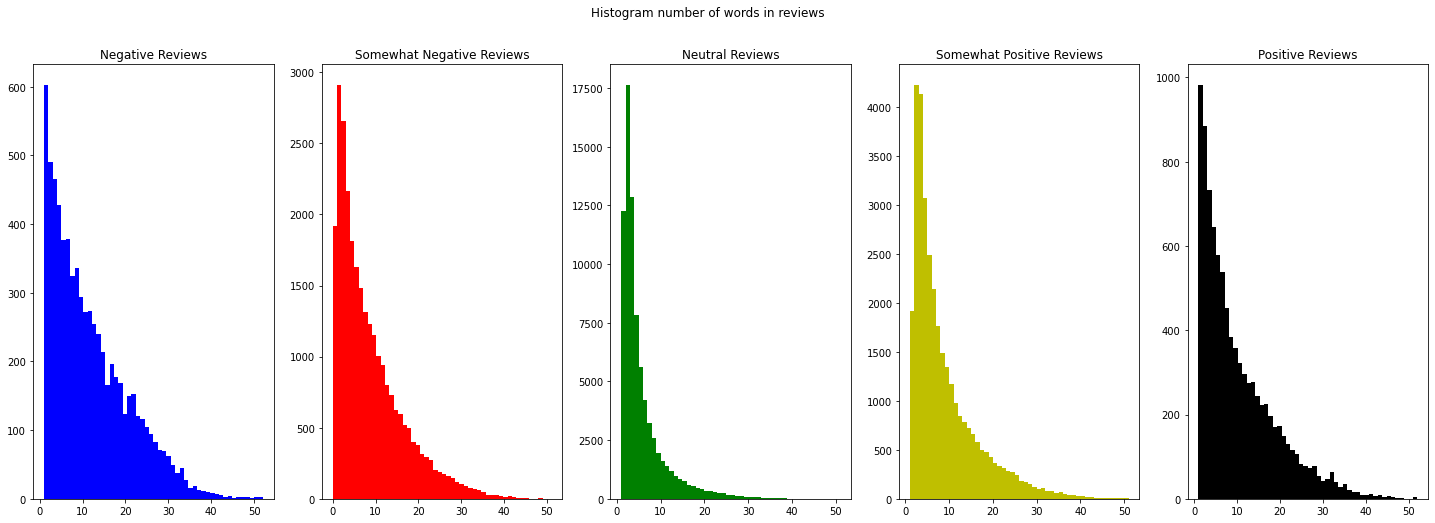

In [6]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))
ax1.hist(train_df[train_df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(train_df[train_df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(train_df[train_df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(train_df[train_df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(train_df[train_df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In [7]:
train_df['Phrase'].str.split().map(lambda x: len(x)).max()

52

***Insights*** <br>
Through these graphs we can see that most reviews of any class are of shorter length, around 5-20. But max length is 52 
Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [8]:

df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


***Insights*** <br>
We can remove sentences which have length more than 40 words and they won't contribute much but removing them can help to boost computation

In [9]:
train_df['len'] = train_df['Phrase'].str.split().map(lambda x: len(x))
print(train_df.shape)

train_df = train_df[train_df['len'] <40 ]
print(train_df.shape)

(156060, 5)
(155708, 5)


In [10]:
156060 - 155708

352

### Step 3. Taking the train data and splitting it into train and val dataset using <tt>**StratifiedSplit()**</tt>

In [11]:
train_df['Sentiment'].value_counts()

2    79525
3    32810
1    27195
4     9146
0     7032
Name: Sentiment, dtype: int64

There is an imbalance . So we cannot do random split, We'll do <tt>**StratifiedSplit()**</tt> to ensure distribution is same in splits


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
X = train_df.drop('Sentiment',axis=1)
y = train_df['Sentiment']
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0) #test size of 10% 

for train_index, test_index in sss.split(X , y):  
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]  
    X_val = X.iloc[test_index]
    y_val = y.iloc[test_index]

### Step 4. Performing text preprocessing like pattern matching using regex , word tokenization , lemmatization

In [13]:
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re


In [14]:
def sentence_cleaning(df):
    sentence = []
    for sent in df['Phrase']:
        
        text = re.sub("[^a-zA-Z]"," ",sent)
        
        word = word_tokenize(text.lower())
        
        lemmatizer = WordNetLemmatizer()
        
        lemm_word = [lemmatizer.lemmatize(i) for i in word]
        
        sentence.append(lemm_word)
    return (sentence)

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [16]:
print(y_train.shape)
print(y_val.shape)

(140137, 5)
(15571, 5)


In [17]:
x_train = sentence_cleaning(X_train)
x_val = sentence_cleaning(X_val)

In [18]:
unique_words = set()
max_len = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if(max_len < len(sent)):
        max_len = len(sent)
        sentence = sent

100%|██████████| 140137/140137 [00:00<00:00, 866607.17it/s]


In [19]:
len(list(unique_words))

13741

In [20]:
max_len

41

In [21]:
vocabulary = len(list(unique_words))
#vocab_size = len(tokenizer.word_index) + 1
oov = '<OOV>'
embedding_dim = 300
padding = 'post'
trunc = 'post'

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
print(x_train[:5])

[['have', 'done'], ['is', 'and'], ['trimmed', 'dickens', 'wonderfully', 'sprawling', 'soap', 'opera', 'the', 'better'], ['saying', 'what', 'he', 'ha', 'long', 'wanted', 'to', 'say', 'confronting', 'the', 'root', 'of', 'his', 'own', 'preoccupation', 'and', 'obsession'], ['an', 'interesting', 'technical', 'exercise']]


In [24]:
tokenizer = Tokenizer(num_words = vocabulary,oov_token = oov,char_level = False)
tokenizer.fit_on_texts(list(x_train))


x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train,maxlen = max_len,padding=padding,truncating = trunc)


x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val,maxlen = max_len,padding=padding,truncating = trunc)

In [25]:
print(x_train.shape)
print(x_val.shape)
print(x_train[0])

(140137, 41)
(15571, 41)
[ 36 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


### Step 5. Buidling LSTM Model

In [26]:
# import gensim.models.keyedvectors as word2vec
# w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=50000)

In [27]:
from keras.models import Model,Input
from keras.layers import Dense,Bidirectional,Activation,Dropout,LSTM,Embedding
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , EarlyStopping

In [28]:
input_vec = Input(shape = (41,))
x = Embedding(vocabulary,embedding_dim,input_length = max_len)(input_vec)
x = Bidirectional(LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True))(x)
x = Bidirectional(LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=False))(x)
x = Dense(50 , activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(5 , activation = 'softmax' , name = 'Sentiment')(x)
model = Model(inputs = [input_vec] , outputs = [x])

2022-02-02 06:51:35.393115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:51:35.568360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:51:35.569147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 06:51:35.570681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 41, 300)           4122300   
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 256)           439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 50)                12850     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 255   

In [30]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [31]:
 callbacks = [
     EarlyStopping(patience=5),
     ReduceLROnPlateau(factor=0.3, patience=3, min_lr=0.00001 ),
     ModelCheckpoint('lstm_model.h5')
 ]

In [32]:
model.fit(x_train,y_train,validation_data = (x_val, y_val),epochs = 30
          ,batch_size = 4196,verbose = 1,callbacks = callbacks)

2022-02-02 06:51:39.104219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
34/34 [==============================] - 41s 941ms/step - loss: 1.2992 - accuracy: 0.4970 - val_loss: 1.1987 - val_accuracy: 0.5238
Epoch 2/30
34/34 [==============================] - 32s 924ms/step - loss: 1.1861 - accuracy: 0.5298 - val_loss: 1.1060 - val_accuracy: 0.5525
Epoch 3/30
34/34 [==============================] - 32s 931ms/step - loss: 1.0812 - accuracy: 0.5732 - val_loss: 0.9937 - val_accuracy: 0.6104
Epoch 4/30
34/34 [==============================] - 32s 930ms/step - loss: 0.9533 - accuracy: 0.6257 - val_loss: 0.9094 - val_accuracy: 0.6395
Epoch 5/30
34/34 [==============================] - 32s 945ms/step - loss: 0.8719 - accuracy: 0.6533 - val_loss: 0.8635 - val_accuracy: 0.6523
Epoch 6/30
34/34 [==============================] - 32s 944ms/step - loss: 0.8304 - accuracy: 0.6671 - val_loss: 0.8510 - val_accuracy: 0.6567
Epoch 7/30
34/34 [==============================] - 32s 942ms/step - loss: 0.8074 - accuracy: 0.6735 - val_loss: 0.8411 - val_accuracy: 0.6564

## Step 6. Evaluating model's performance

In [33]:
y_val_pred = model.predict(x_val)


In [34]:
y_val_pred.shape

(15571, 5)

In [35]:
y_val_pred_max = np.argmax(y_val_pred , axis = 1)
y_val_gt_max = np.argmax(y_val , axis = 1)

print(y_val_pred_max.shape)
print(y_val_gt_max.shape)


(15571,)
(15571,)


In [36]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(y_val_pred_max, y_val_gt_max)

print(report)

              precision    recall  f1-score   support

           0       0.40      0.50      0.44       565
           1       0.57      0.54      0.56      2890
           2       0.79      0.76      0.78      8261
           3       0.54      0.58      0.56      3024
           4       0.50      0.55      0.52       831

    accuracy                           0.66     15571
   macro avg       0.56      0.59      0.57     15571
weighted avg       0.67      0.66      0.67     15571



AxesSubplot(0.125,0.125;0.62x0.755)


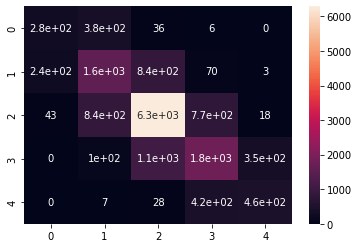

In [37]:
import seaborn as sns
print(sns.heatmap(confusion_matrix(y_val_gt_max , y_val_pred_max) , annot=True))

## The model is having an f1 score of 0.67 which can be further improved if we use the pretrained word embeddings